# Loading Packages & Initialization

reference : https://gist.github.com/mertedali/ab7078b9c29dea18c72525239d636b96

In [2]:
rm(list=ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs) # For maximin Latin hypercube sampling
library(ggplot2)
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr) # for evaluating predictive power

require(gridExtra)

options(warn = -1)

In [3]:
# Select if data generation is wanted
GenerateTTData <- 0

In [4]:
Is_Headless <- 1
nl.model <- "Segregation_Dummy"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
model.path <- paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/",nl.model,".nlogo")

if (Is_Headless == 0){
    NLStart(nl.path, gui = TRUE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    } else {
    NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    
    #NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar', nl.obj = nl.model)
    #NLLoadModel (model.path, nl.obj = nl.model )
    }

# Model Parameters & Functions

## Set model parameters

In [5]:
set.seed(1)

## Set model parameters
 # Number of replications for each instance
nofrep = 1     

# Number of iterations
numiter = 10
 # order feature names according to their definition order in run_model
feature_names = c("density","%-similar-wanted","budget-multiplier-dummy","density-multiplier-dummy","noise-dummy","tick-limit")  
 # 
output_name = c("percent-similar")

 # Number of input parameters of the agent-based model
nofparams = length(feature_names)      

# set RF parameters
ntree = 400
mtry = 2

## Set user parameters

In [6]:
error_type = "RMSE" # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "sd" #, "range" 

unlabeled_ins = 700 
test_ins = 400
train_ins_oneshot = 700
train_ins_Ad = 200

# Set selection parameters
selected_ins = 5 #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1 # number of variables eliminated in each step


## Define functions

### run_model

In [7]:
#run_model <- function(feature_names,feature_values){ # both should be in character list format
run_model <- function(feature_values){ # both should be in character list format

    
    k = length(feature_names)    
    for(i in 1:k){
        NLCommand(paste0("set ",feature_names[i]," ",feature_values[i]))      
    }
    NLCommand("setup")
    NLDoCommand(100, "go") 
    result <- NLReport(output_name)
    return(result)   
}

### run_replicas

In [8]:
#run_replicas <- function(nofrep,feature_names,feature_values) {
run_replicas <- function(nofrep,feature_values) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1) # Save the result of each replication
    for(i in 1:nofrep){
     #   replicas[i]= run_model(feature_names,feature_values)
        replicas[i]= run_model(feature_values)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}

### run_ABM

In [9]:
#run_ABM = function(nofrep,nofinstances,unlabeledset,featurenames = feature_names){
run_ABM = function(nofrep,nofinstances,unlabeledset){
   #unlabeledset = setcolorder(unlabeledset,featurenames) 
   unlabeledset = setcolorder(unlabeledset,feature_names) 
   for(i in 1:nofinstances){
        #unlabeledset[i, output :=  run_replicas(nofrep,featurenames, as.matrix(unlabeledset[i,]))]    
        unlabeledset[i, output :=  run_replicas(nofrep, as.matrix(unlabeledset[i,]))] 
    } 
    return(unlabeledset)
}


### error functions

In [10]:
#error functions on test data
rmse_func <- function(actual, predicted){
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual,predicted){
    return( (abs(actual - predicted)/ actual)*100 )
}

bias_func <- function(actual,predicted){
    return( (actual - predicted)/ actual )
}

#error functions on train data
obb_error_func <- function(model){
   if(model$type == "regression"){
        oob_error = model$mse[model$ntree] 
    }else if(model$type == "classification"){
        oob_error = model$err.rate 
    } 
    return(oob_error)
}


### get_test_predictions

In [11]:
# prediction functions
get_test_predictions <- function(model,testset,errortype){
    
    predictedLabels <- predict(model, testset)
    predictedLabels <- cbind(testset,predictedLabels)
    setnames(predictedLabels, "predictedLabels","pred_output")

    output_variables = colnames(select(predictedLabels, contains("output")))
    # output_variables[1] = true output
    # output_variables[2] = predicted output
    
    #output_variables = colnames(predictedLabels[,1:(ncol(predictedLabels) - 2)])
    
    if(error_type == "MAPE"){
        predictedLabels[,MAPE := mapply(function(x,y) mape_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "RMSE"){
        predictedLabels[,RMSE := mapply(function(x,y) rmse_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "BIAS"){
        predictedLabels[,BIAS := mapply(function(x,y) bias_func(x,y),get(output_variables[1]),get(output_variables[2]))]
           } 
                                  
     output_variables_1 = predictedLabels[,get(output_variables[1]), with = TRUE]
     output_variables_2 = predictedLabels[,get(output_variables[2]), with = TRUE]
    
     performance_temp = matrix(c(1:3), nrow = 1, ncol = 3)
     performance_temp[1] =  mae(output_variables_1 , output_variables_2)
     performance_temp[2] = rmse(output_variables_1 , output_variables_2)
     performance_temp[3] = mape(output_variables_1 , output_variables_2)
    
    return(list(predictedLabels,performance_temp,output_variables))
    
} 

### sample_selection

In [12]:
# Adaptive sample selection function with an uncertainty measure depending on "selection_metric"
sample_selection <- function(selected_ins,unlabeled_set,model){
    ind_pred <- t(predict(model, unlabeled_set,predict.all = TRUE)$individual) %>%
                data.table() # predictions by each tree in the forest
    ind_pred_eval = data.table()
    
    # standard deviation calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev,".","sd")
    ind_pred_eval = cbind(ind_pred_eval,s_dev)
    
    # range calculation
    range = sapply(ind_pred, range) %>% t() %>% data.table()
    range = range[,.(range = abs(range[,1] - range[,2]))]
    setnames(range,"range.V1","range")
    ind_pred_eval = cbind(ind_pred_eval,range)
        
    ind_pred_eval[,idx := 1:.N]
    
    if(selection_metric == "sd") {
      ind_pred_eval = ind_pred_eval[order(-sd)][1:selected_ins]
    }else if(selection_metric == "range"){
      ind_pred_eval = ind_pred_eval[order(-range)][1:selected_ins]
    }
    
    unlabeled_set[,idx := 1:.N]    
    train_candidates = unlabeled_set[ind_pred_eval$idx]
    
    return(train_candidates)
}

### random_sample_selection

In [13]:
# Random sample selection
random_sample_selection <- function(selected_ins,unlabeled_set){
  
    unlabeled_set[,idx := 1:.N]
    
    train_candidate_idx = sample(unlabeled_set$idx, selected_ins, replace = FALSE, prob = NULL)   
    train_candidates = unlabeled_set[idx %in% train_candidate_idx]
    
    return(train_candidates)
}

### get_variable_importance

In [14]:
get_variable_importance <- function(model){
    importances <- importance(model, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ranked_features = feature_names[selected.vars]
    ordered.importances <- importances[selected.vars]
    
    return(ranked_features)
}                      

### feature_elimination

In [15]:
feature_elimination <- function(h,total_numof_eliminated_vars,ranked_features){ 
    numof_columns_left = length(ranked_features) - (total_numof_eliminated_vars + h)
    columns_left = ranked_features[1:numof_columns_left]
    
    eliminated_columns = setdiff((length(ranked_features) - total_numof_eliminated_vars), numof_columns_left)
    eliminated_columns = ranked_features[eliminated_columns]
    
    # update total_numof_eliminated_vars
    total_numof_eliminated_vars = length(ranked_features) - length(columns_left)
    
    return(list(columns_left,total_numof_eliminated_vars,h,eliminated_columns))
 }

# Generate Unlabeled Data Pool

## Latin hyper cube sampling

In [16]:
if(GenerateTTData == 1){
    unlabeled_pool = as.data.table(maximinLHS(n = unlabeled_ins, k = nofparams, dup = 5))
    
    unlabeled_pool$V1 = qunif(unlabeled_pool$V1, 10, 90) 
    unlabeled_pool$V2 = qunif(unlabeled_pool$V2, 10, 90)
    unlabeled_pool$V3 = qunif(unlabeled_pool$V3, 1, 10) 
    unlabeled_pool$V4 = qunif(unlabeled_pool$V4, 0.01, 1)    
    unlabeled_pool$V5 = qunif(unlabeled_pool$V5, 0.00001, 0.0001) 
    unlabeled_pool$V6 = qunif(unlabeled_pool$V6, 90, 110)  
    
    setnames(unlabeled_pool, c(paste0("V",1:nofparams)), feature_names)
    
    unlabeled_pool[,idx := 1:.N]
        
    fwrite(unlabeled_pool, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_",Sys.Date(),".csv"))
}else{
    unlabeled_pool <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_2019-12-20.csv")   
}

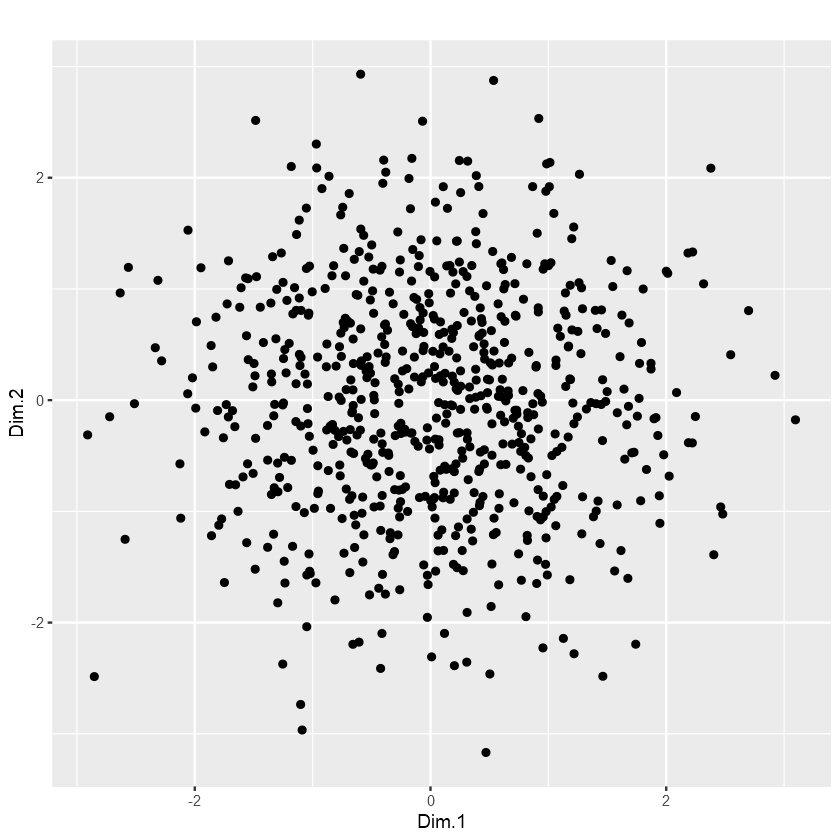

In [17]:
pca_unlabeled_pool <- princomp(unlabeled_pool[,-c("idx")], cor = TRUE, scores = TRUE)
pca_unlabeled_pool_components <- get_pca_ind(pca_unlabeled_pool)
p_unlabeled_pool <- ggplot(data = data.table(pca_unlabeled_pool_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_unlabeled_pool


# Generate Test Set

In [18]:
if(GenerateTTData == 1){
    test_set <- head(unlabeled_pool,test_ins)
    
    ################## Buraya variale'ların datatipine göre bir şeyler yazılabilir
    test_set$density                    = runif(test_ins, 10, 90) 
    test_set$`%-similar-wanted`         = runif(test_ins, 10, 90) 
    test_set$`budget-multiplier-dummy`  = runif(test_ins, 1, 10) 
    test_set$`density-multiplier-dummy` = runif(test_ins, 0.01, 1) 
    test_set$`noise-dummy`              = runif(test_ins, 0.00001, 0.0001) 
    test_set$`tick-limit`               = runif(test_ins, 90, 110) 
    
    test_set[,c("idx"):= NULL]
      
    print(paste0("ABM run start time : ",Sys.time()))
    test_set = run_ABM(nofrep,test_ins,test_set) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(test_set, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_",Sys.Date(),".csv"))
}else{
    test_set <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_2019-12-20.csv")  
}

10 * 10 ~ 1 min
100 * 10 ~ 14 min
900 * 10 ~ 09:16 -- 2019-12-03 07:54:10 +03"

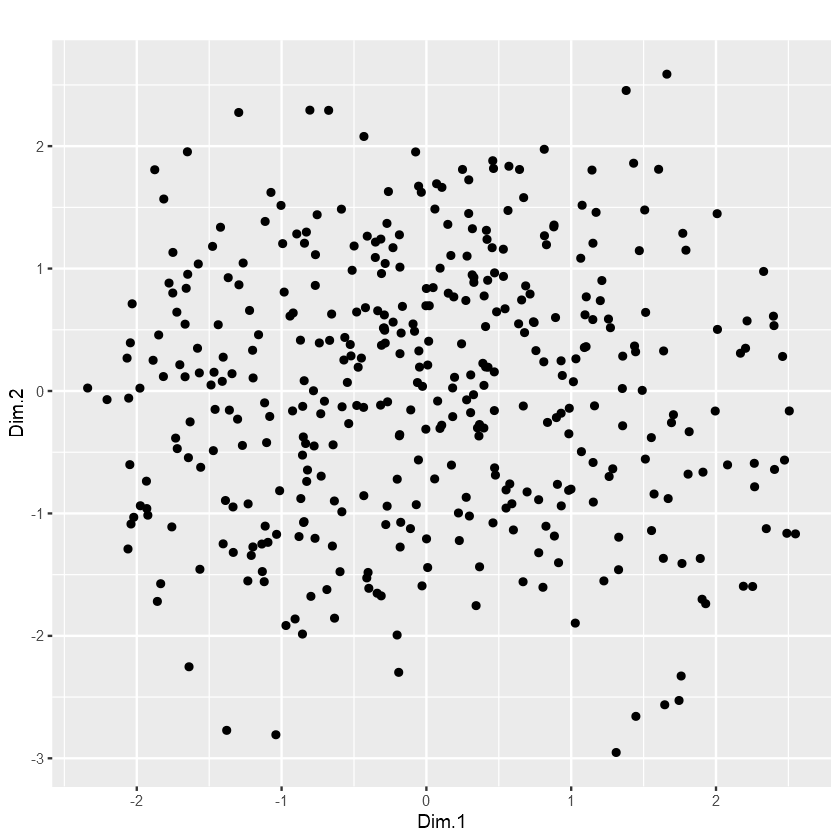

In [19]:
pca_test_set <- princomp(test_set, cor = TRUE, scores = TRUE)
pca_test_set_components <- get_pca_ind(pca_test_set)
p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_test_set

# Benchmark : One-shot sampling, No feature elimination

## Generate Training Set

Select a very big data pool ( nofinstances should be very high ) , like 1000

In [20]:
if(GenerateTTData == 1){
    training_set = as.data.table(maximinLHS(n = train_ins_oneshot, k = nofparams, dup = 5))
    
    training_set$V1 = qunif(training_set$V1, 10, 90) 
    training_set$V2 = qunif(training_set$V2, 10, 90) 
    training_set$V3 = qunif(training_set$V3, 1, 10) 
    training_set$V4 = qunif(training_set$V4, 0.01, 1)    
    training_set$V5 = qunif(training_set$V5, 0.00001, 0.0001) 
    training_set$V6 = qunif(training_set$V6, 90, 110)  
    
    setnames(training_set, c(paste0("V",1:nofparams)), feature_names)
   
    training_set$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    training_set = run_ABM(nofrep,train_ins_oneshot,LHSample) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(training_set, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/training_set_",Sys.Date(),".csv"))
    
}else{
    training_set <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_2019-12-20.csv")
}

In [21]:
one_shot_data = copy(training_set)

### Visualization

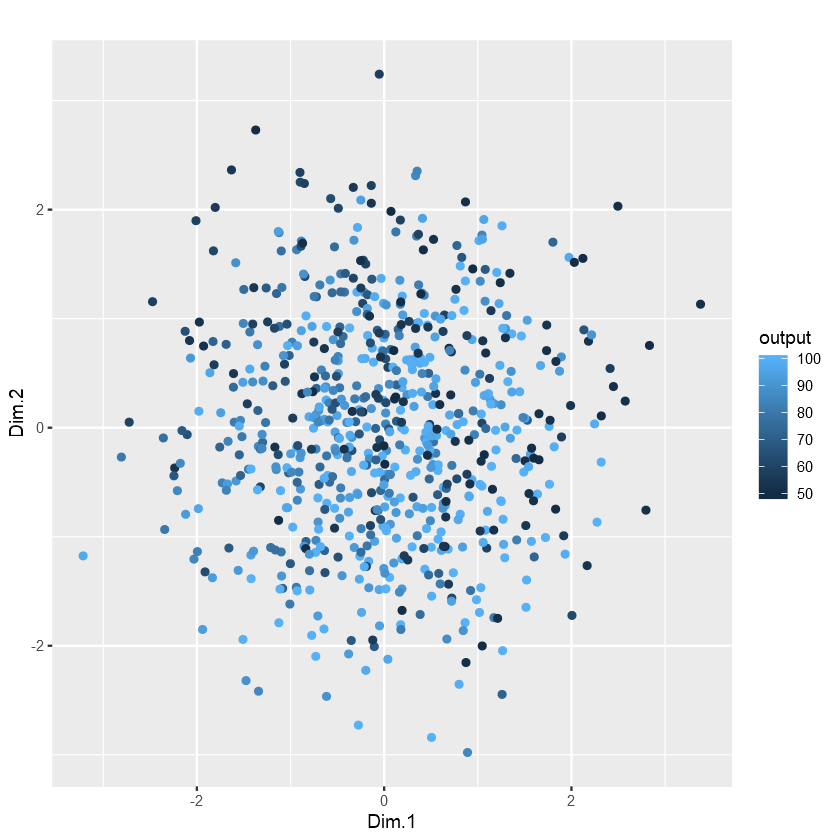

In [22]:
pca_training_set <- princomp(training_set[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_training_set_components <- get_pca_ind(pca_training_set)
pca_training_set_components <-cbind(pca_training_set_components$coord[,1:2],training_set[,.SD, .SDcols = c("output")])
p_training_set <- ggplot(data = pca_training_set_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_training_set

## Train & Test Metamodel

In [23]:
model_oneshot <- randomForest(x = training_set[, -c("output")], y = training_set$output, importance = TRUE,ntree = ntree, mtry = mtry)
model_oneshot


Call:
 randomForest(x = training_set[, -c("output")], y = training_set$output,      ntree = ntree, mtry = mtry, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 400
No. of variables tried at each split: 2

          Mean of squared residuals: 28.61753
                    % Var explained: 90.58

In [24]:
obb_error_oneshot <- obb_error_func(model_oneshot)

In [ ]:
#OBB_pred = cbind(training_set$output,model_oneshot$predicted)
#names(OBB_pred) <- c("actual","predicted")

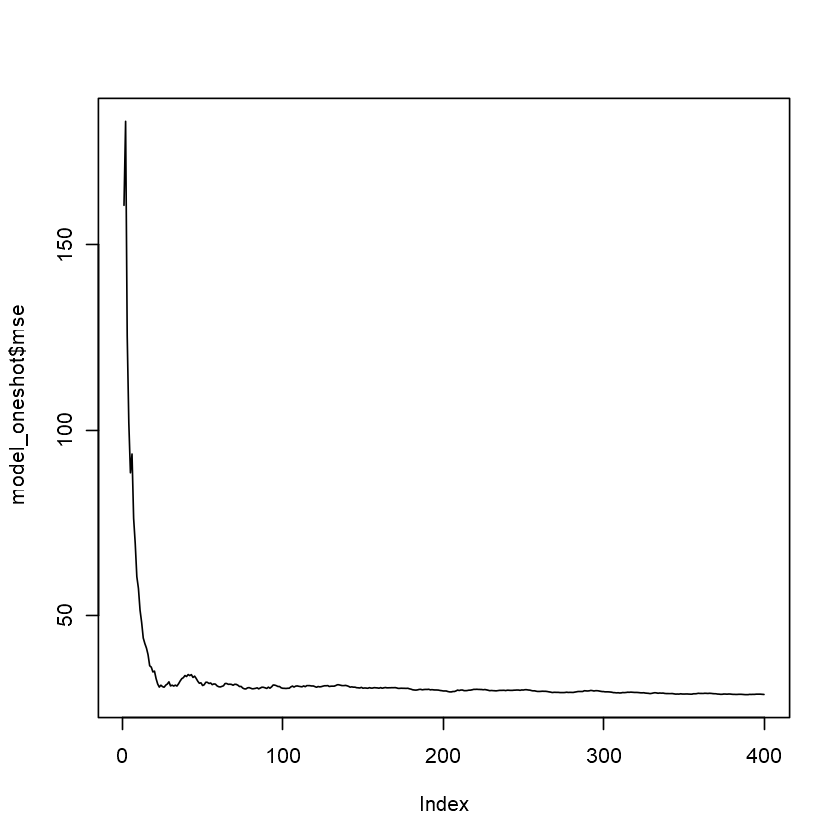

In [25]:
plot(model_oneshot$mse, type="l")

In [26]:
test_prediction_oneshot = get_test_predictions(model_oneshot,test_set,error_type)
predictedLabels_oneshot = test_prediction_oneshot[[1]]

performance_table_oneshot = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())
# Keep test set error records
performance_table_oneshot = rbind(performance_table_oneshot, data.table(1, test_prediction_oneshot[[2]]), use.names = FALSE)

output_variables = test_prediction_oneshot[[3]]

ERROR: Error in rbindlist(l, use.names, fill, idcol): Item 2 has 3 columns, inconsistent with item 1 which has 4 columns. To fill missing columns use fill=TRUE.


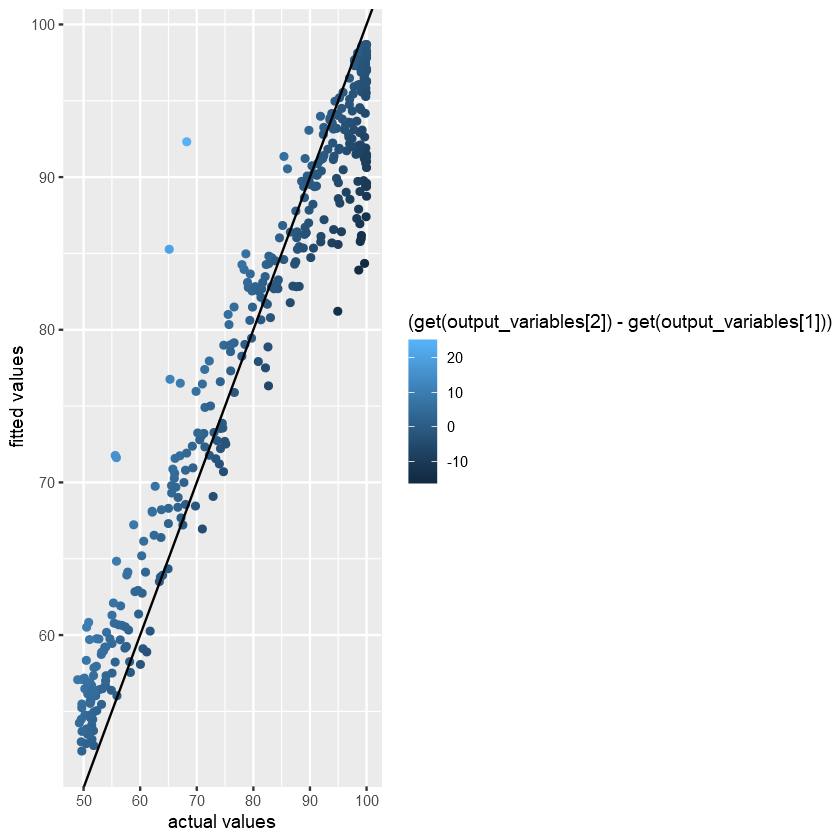

In [36]:
p_oneshot <- ggplot(predictedLabels_oneshot,aes(x = get(output_variables[1]), y = get(output_variables[2]), color = (get(output_variables[2]) - get(output_variables[1])))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values")

p_oneshot

# Random Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [37]:
if(GenerateTTData == 1){
   
    training_set_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
    
    training_set_Ad$V1 = qunif(training_set_Ad$V1, 10, 90) 
    training_set_Ad$V2 = qunif(training_set_Ad$V2, 10, 90)
    training_set_Ad$V3 = qunif(training_set_Ad$V3, 1, 10) 
    training_set_Ad$V4 = qunif(training_set_Ad$V4, 0.01, 1)    
    training_set_Ad$V5 = qunif(training_set_Ad$V5, 0.00001, 0.0001) 
    training_set_Ad$V6 = qunif(training_set_Ad$V6, 90, 110) 
    
    setnames(training_set_Ad, c(paste0("V",1:nofparams)), feature_names)
    training_set_Ad$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    training_set_Ad = run_ABM(nofrep,train_ins_Ad,training_set_Ad) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(training_set_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/training_set_Ad",Sys.Date(),".csv"))

}else{
    training_set_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_2019-12-20.csv")
}

In [38]:
adaptive_initial_data = copy(training_set_Ad)

## Train & Test Metamodel

In [39]:
# Decide on strategy:
iteration_budget = 3

## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

In [40]:
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
                     
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)
    
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)    

    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.
        
    ## sample selection from unlabeled data select candidates
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = random_sample_selection(selected_ins,unlabeled_set)
        
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # run ABM to find outputs of train candidates
    print(paste0("ABM train_candidate run start time : ",Sys.time()))
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    print(paste0("ABM train_candidate run end time : ",Sys.time()))
    
    train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))

    # Add new data to train data
    training_set_Ad = rbind(training_set_Ad,train_candidates[,-c("idx")])
    }
    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!


[1] 1
[1] "ABM train_candidate run start time : 2020-01-07 18:04:53"
[1] "ABM train_candidate run end time : 2020-01-07 18:05:00"
[1] 2
[1] "ABM train_candidate run start time : 2020-01-07 18:05:01"
[1] "ABM train_candidate run end time : 2020-01-07 18:05:04"
[1] 3


In [41]:
# Final records
FinalTrainData_Rd = copy(training_set_Ad)
performance_table_Rd = copy(performance_table)
train_candidates_table_Rd  = copy(train_candidates_table)
predictedLabels_table_Rd = copy(predictedLabels_table)
obb_error_Rd = copy(obb_error)

In [42]:
# show results
nrow(FinalTrainData_Rd)
performance_table_Rd 
train_candidates_table_Rd  
head(predictedLabels_table_Rd)
obb_error_Rd

[1] 210

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.243684,7.849467,8.775010
2,6.361725,8.018078,8.909286
3,6.136352,7.761452,8.682411


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
71.28812,51.46540,2.140200,0.24978951,3.648172e-05,94.55682,57,94.37782,1
25.87072,71.93649,7.551367,0.59146457,2.936624e-05,101.52524,114,99.90970,1
30.79384,40.94736,5.057692,0.54736048,5.046197e-05,107.57766,145,93.46695,1
81.37530,81.28151,9.289525,0.51114474,8.039323e-05,93.96923,261,51.82562,1
55.34717,45.92310,5.961940,0.33538086,7.345333e-05,99.55940,669,89.60344,1
36.74606,24.81893,9.081172,0.73983351,7.211296e-05,92.80358,203,70.41965,2
76.98807,63.28420,3.834744,0.06490567,6.087533e-05,102.61920,300,98.67807,2
36.98882,76.30004,2.948129,0.64875665,7.577111e-05,99.00537,367,75.74501,2
45.74897,68.00404,7.987176,0.96421923,1.675996e-05,102.26377,388,99.76249,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,pred_output_3,RMSE_3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,79.87295,18.747913,79.14310,19.477770,79.90561,18.715255
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,74.45472,8.363821,75.00681,8.915916,74.47679,8.385893
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,89.91434,3.376239,90.22563,3.687526,89.33057,2.792467
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,92.35617,4.711029,92.03469,5.032507,91.97546,5.091734
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,71.20232,2.791248,72.77279,1.220777,72.74010,1.253462
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.01950,6.342820,69.35611,5.679432,69.77588,6.099204


iter,obb_error
<dbl>,<dbl>
1,68.52227
2,70.73185
3,66.05550


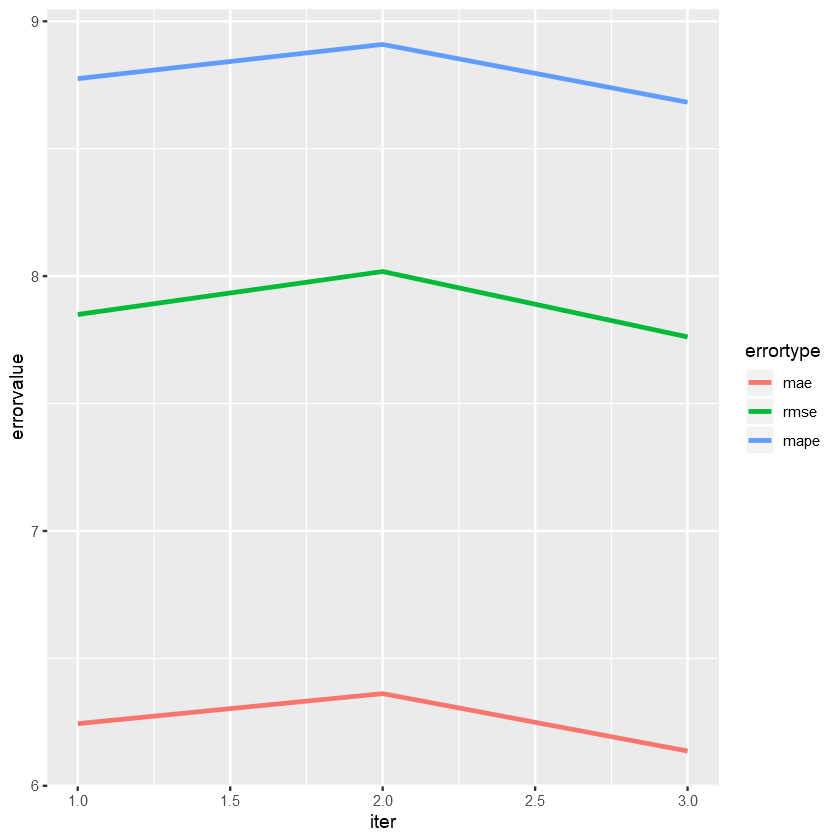

In [43]:
performance_molten_Rd <- melt(data = performance_table_Rd
                             , id.vars = 'iter')
setnames(performance_molten_Rd, c("variable","value"),c("errortype","errorvalue"))
p_Rd = ggplot(performance_molten_Rd, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
          geom_line(lwd=1)
p_Rd

# Adaptive Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [44]:
training_set_Ad = copy(adaptive_initial_data)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90],300)
#
#}

### Visualization

In [45]:
pca_training_set_Ad <- princomp(training_set_Ad[,-c("output")], cor = TRUE, scores = TRUE)

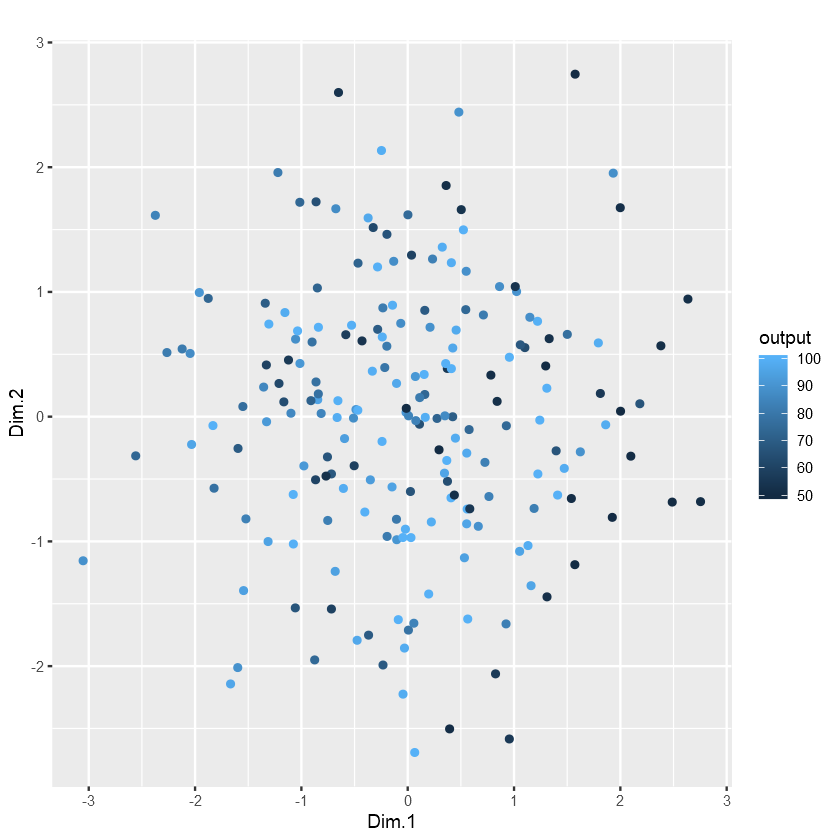

In [46]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_training_set_Ad_components <- get_pca_ind(pca_training_set_Ad)
pca_training_set_Ad_components <-cbind(pca_training_set_Ad_components$coord[,1:2],training_set_Ad[,c("output")])
p_training_set_Ad <- ggplot(data = pca_training_set_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_training_set_Ad

## Train & Test Metamodel

In [47]:
# Decide on strategy:
iteration_budget = 3

h = 1 # specify how many variable will be eliminated in each elimination iteration

In [48]:
## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

In [49]:
print(Sys.time())
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
                    
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)

    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.    
    ## sample selection from unlabeled data select candidates
        unlabeled_set <- copy(unlabeled_pool)
        train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
        
        # eliminate candidates from the unlabeled pool
        unlabeled_pool = unlabeled_pool[-train_candidates$idx]
        rm(unlabeled_set)
        
        # run ABM to find outputs of train candidates
        paste0("ABM train_candidate run start time : ", Sys.time())
        train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
        paste0("ABM train_candidate run end time : ", Sys.time())
        
        train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
        
        # add labeled candidates to the train data
        training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
    }
    iter = iter + 1
}

[1] 1
[1] 2
[1] 3


In [50]:
# Final records
FinalTrainData_Ad = copy(training_set_Ad)
performance_table_Ad = copy(performance_table)
train_candidates_table_Ad  = copy(train_candidates_table)
predictedLabels_table_Ad = copy(predictedLabels_table)
obb_error_Ad = copy(obb_error)

In [51]:
nrow(FinalTrainData_Ad)
performance_table_Ad
train_candidates_table_Ad
head(predictedLabels_table_Ad)
obb_error_Ad

[1] 210

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.298179,7.870022,8.858668
2,6.080113,7.516607,8.545024
3,5.918244,7.211168,8.257147


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
52.77261,74.38122,9.310490,0.43777360,5.293214e-05,108.28870,505,99.92273,1
13.16295,81.92370,4.918442,0.90748670,5.156864e-05,108.65117,342,96.39180,1
10.41457,89.91221,1.036082,0.57597604,7.662668e-05,109.04119,669,100.00000,1
56.28091,82.52071,2.074132,0.06706306,5.985505e-05,92.17322,583,51.52920,1
59.26529,75.16035,2.470868,0.39089915,3.816702e-05,105.17168,62,55.96617,1
66.01900,88.67981,1.050862,0.05744754,9.129029e-05,109.94240,661,49.03045,2
34.11864,89.13136,1.133751,0.34217479,2.966778e-05,107.82599,382,57.78123,2
44.57960,74.76277,5.121159,0.99222654,4.274789e-05,106.00483,326,99.90051,2
56.96093,81.45353,1.528351,0.25268715,7.777971e-05,98.44494,361,51.34994,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,pred_output_3,RMSE_3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,78.97405,19.646821,79.23814,19.382725,79.76599,18.854876
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,74.67845,8.587558,75.03403,8.943135,73.68602,7.595128
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,88.82621,2.288106,89.89553,3.357431,89.83409,3.295988
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,91.46645,5.600749,92.36852,4.698676,90.26024,6.806960
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,72.14492,1.848645,71.98088,2.012689,71.78485,2.208718
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,69.98714,6.310467,69.85168,6.175001,69.85881,6.182127


iter,obb_error
<dbl>,<dbl>
1,70.63951
2,66.26870
3,71.76128


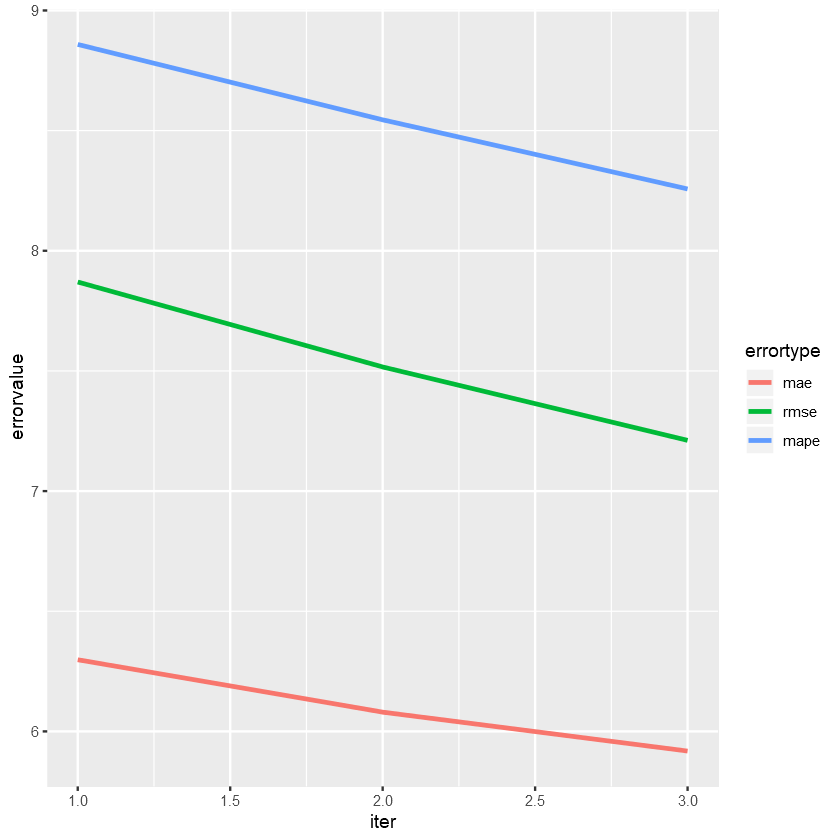

In [52]:
performance_molten_Ad <- melt(data = performance_table_Ad
                             , id.vars = 'iter')
setnames(performance_molten_Ad, c("variable","value"),c("errortype","errorvalue"))
p_Ad = ggplot(performance_molten_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1)
p_Ad

# Random Sampling vs Uncertainty Sampling

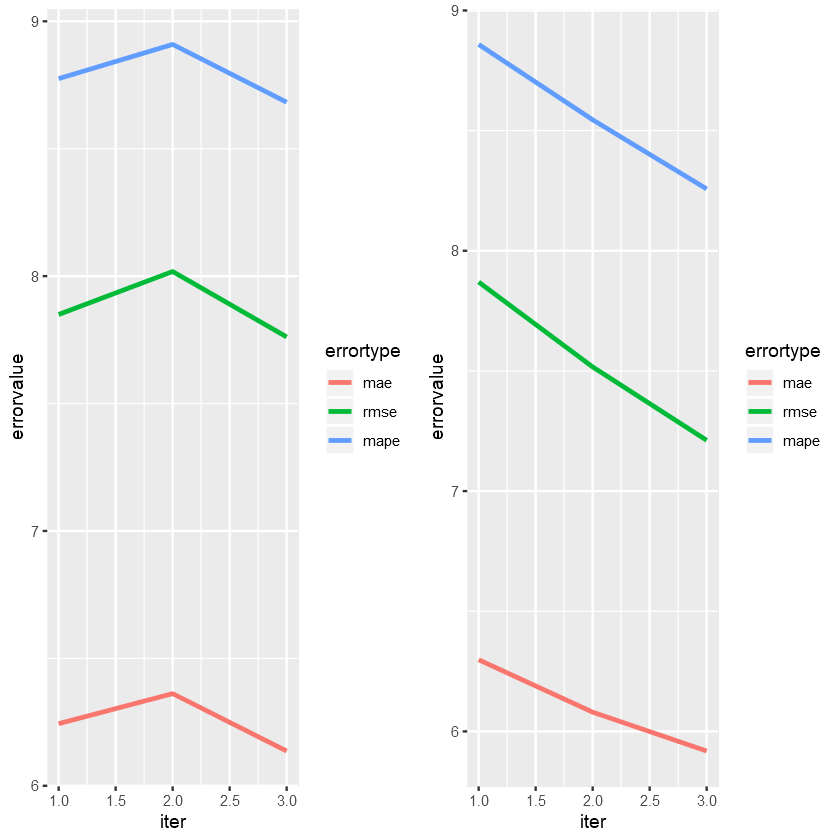

In [53]:
grid.arrange(p_Rd, p_Ad, ncol=2)

# Adaptive Sampling & Feature Elimination 

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [54]:
training_set_Ad = copy(adaptive_initial_data)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90],300)
#
#}

### Visualization

In [55]:
pca_training_set_Ad <- princomp(training_set_Ad[,-c("output")], cor = TRUE, scores = TRUE)

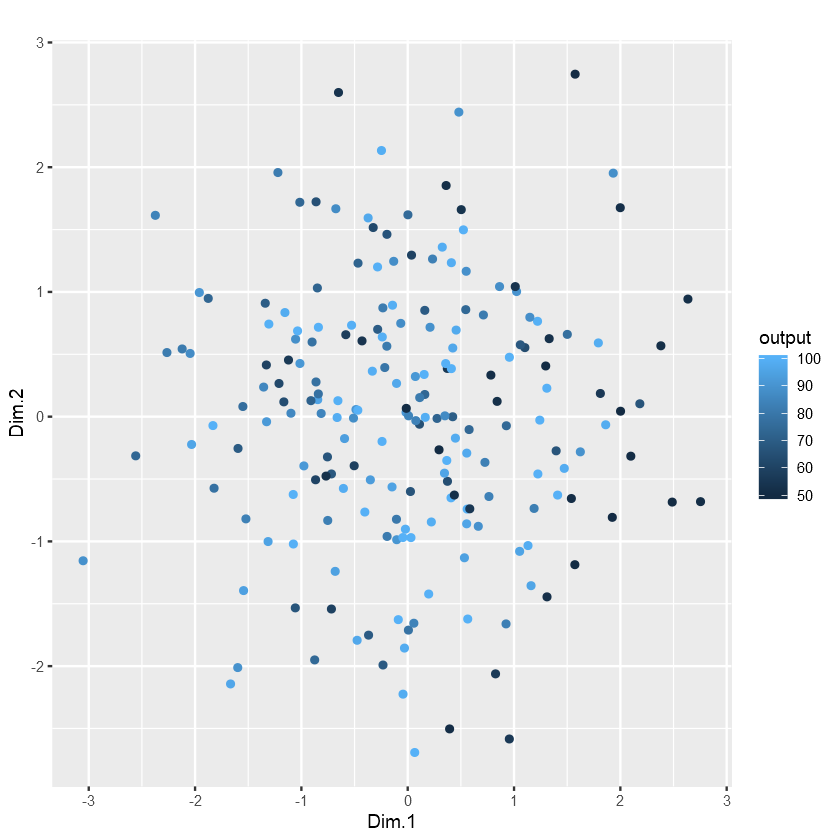

In [56]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_training_set_Ad_components <- get_pca_ind(pca_training_set_Ad)
pca_training_set_Ad_components <-cbind(pca_training_set_Ad_components$coord[,1:2],training_set_Ad[,c("output")])
p_training_set_Ad <- ggplot(data = pca_training_set_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_training_set_Ad

## Train & Test Metamodel

In [57]:
# Decide on strategy:
sample_selection_iteration_order = c(1,3)
feature_elimination_iteration_order = c(2,3)
iteration_budget = 3 # should be > max(max(sample_selection_iteration_order),max(feature_elimination_iteration_order))

h = 1 # specify how many variable will be eliminated in each elimination iteration

In [58]:
## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

# Record iteration history
iteration_history = data.table(iter_no = numeric(), IsFeatureEliminated = logical(), IsDataSelected = logical())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

# specify variables(columns) to be used initialize
columns_left = feature_names
total_numof_eliminated_vars <- 0

In [59]:
iter = 1
while (iter <= iteration_budget) {
    
    trainx = training_set_Ad[, .SD, .SDcols = columns_left]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest(x = trainx, y = trainy, importance = TRUE, ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_", iter), model_Sub)
    
    if (length(columns_left) == length(feature_names)) {
        ranked_features = get_variable_importance(model_Sub)
    }
    # Keep training set error records
    obb_error = rbind(obb_error, data.table(iter, obb_error_func(model_Sub)), use.names = FALSE)
    
    # Test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub, test_set, error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table, data.table(iter, test_predictions_Sub[[2]]), use.names = FALSE)
    
    # update iteration_history
    iteration_history = rbind(iteration_history, data.table(iter, 0, 0), use.names = FALSE)
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.
          if (iter %in% sample_selection_iteration_order) {
              ## sample selection from unlabeled data select candidates
              unlabeled_set <- copy(unlabeled_pool)
              train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
              
              # eliminate candidates from the unlabeled pool
              unlabeled_pool = unlabeled_pool[-train_candidates$idx]
              rm(unlabeled_set)
              
              # run ABM to find outputs of train candidates
              paste0("ABM train_candidate run start time : ", Sys.time())
              train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
              paste0("ABM train_candidate run end time : ", Sys.time())
              
              train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
              
              # add labeled candidates to the train data
              training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
              
              # update iteration_history
               iteration_history[iter]$IsDataSelected= 1
          }
          if (iter %in% feature_elimination_iteration_order) {
              ## feature elimination apply feature elimination
              feature_elimination_result = feature_elimination(h, total_numof_eliminated_vars, ranked_features)
              
              columns_left = feature_elimination_result[[1]]  # 
              eliminated_columns = feature_elimination_result[[4]]  #   not necessary
              total_numof_eliminated_vars = as.numeric(feature_elimination_result[2])
              numof_eliminated_vars = as.numeric(feature_elimination_result[3])  #   not necessary 
              
              # update iteration_history
              iteration_history[iter]$IsFeatureEliminated= 1
          }
    }
iter = iter + 1  
}

In [ ]:
#if(iter %in% sample_selection_iteration_order){
#   ## sample selection from unlabeled data
#   # select candidates
#   unlabeled_set <- copy(unlabeled_pool)
#   train_candidates = sample_selection(selected_ins,unlabeled_set,model_Sub)
#   
#   # eliminate candidates from the unlabeled pool
#   unlabeled_pool = unlabeled_pool[- train_candidates$idx]
#   rm(unlabeled_set)
#   
#   # run ABM to find outputs of train candidates
#   paste0("ABM train_candidate run start time : ",Sys.time())
#   train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
#   paste0("ABM train_candidate run end time : ",Sys.time())
#   
#   train_candidates_table = rbind(train_candidates_table, data.table(train_candidates, "iter" = iter))
#   
#   # add labeled candidates to the train data
#   LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])
#   
#   # update iteration_history
#   iteration_history[iter == iter,IsDataSelected := 1 ]
#}

In [ ]:
#if(iter %in% feature_elimnation_iteration_order){
#   ## feature elimination
#   # apply feature elimination
#       feature_elimination_result = feature_elimination(h,total_numof_eliminated_vars,ranked_features)
#   
#       columns_left = feature_elimination_result[[1]]# 
#       eliminated_columns = feature_elimination_result[[4]]#   not necessary
#       total_numof_eliminated_vars = as.numeric(feature_elimination_result[2])  
#       numof_eliminated_vars = as.numeric(feature_elimination_result[3])#   not necessary 
#   
#   # update iteration_history
#   iteration_history["iter" == iter,IsFeatureEliminated := 1 ]
#}

In [60]:
# Final records
FinalTrainData_AdFe = copy(training_set_Ad)
performance_table_AdFe = copy(performance_table)
train_candidates_table_AdFe  = copy(train_candidates_table)
predictedLabels_table_AdFe = copy(predictedLabels_table)
obb_error_AdFe = copy(obb_error)

In [61]:
nrow(FinalTrainData_AdFe)
performance_table_AdFe
train_candidates_table_AdFe
head(predictedLabels_table_AdFe)
obb_error_AdFe

[1] 205

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.490675,8.084659,9.127758
2,6.149757,7.692322,8.738412
3,4.906633,6.325642,6.911562


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
13.37395,88.40317,3.449100,0.07868366,8.048873e-05,108.1572,534,100.00000,1
54.16357,69.35888,4.615526,0.74936027,1.294256e-05,109.7390,490,99.82356,1
49.90584,75.01995,7.645617,0.54757642,7.311075e-05,104.2117,149,59.37507,1
50.40119,66.54958,1.710772,0.34678774,5.129994e-05,109.5426,594,98.47705,1
89.29542,60.67241,3.282788,0.47527160,1.300112e-05,109.2735,450,98.24814,1


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,pred_output_3,RMSE_3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,78.79977,19.821101,78.83966,19.781206,81.20692,17.413952
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,74.88242,8.791521,75.36165,9.270758,72.46340,6.372502
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,88.92451,2.386411,89.48929,2.951193,89.54938,3.011282
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,92.54175,4.525449,91.43071,5.636489,94.04635,3.020851
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,71.76169,2.231870,72.73625,1.257318,72.83681,1.156759
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.51215,6.835476,72.11992,8.443237,71.02964,7.352959


iter,obb_error
<dbl>,<dbl>
1,73.23465
2,66.07822
3,48.26303


In [62]:
iteration_history

iter_no,IsFeatureEliminated,IsDataSelected
<dbl>,<dbl>,<dbl>
1,0,1
2,1,0
3,0,0


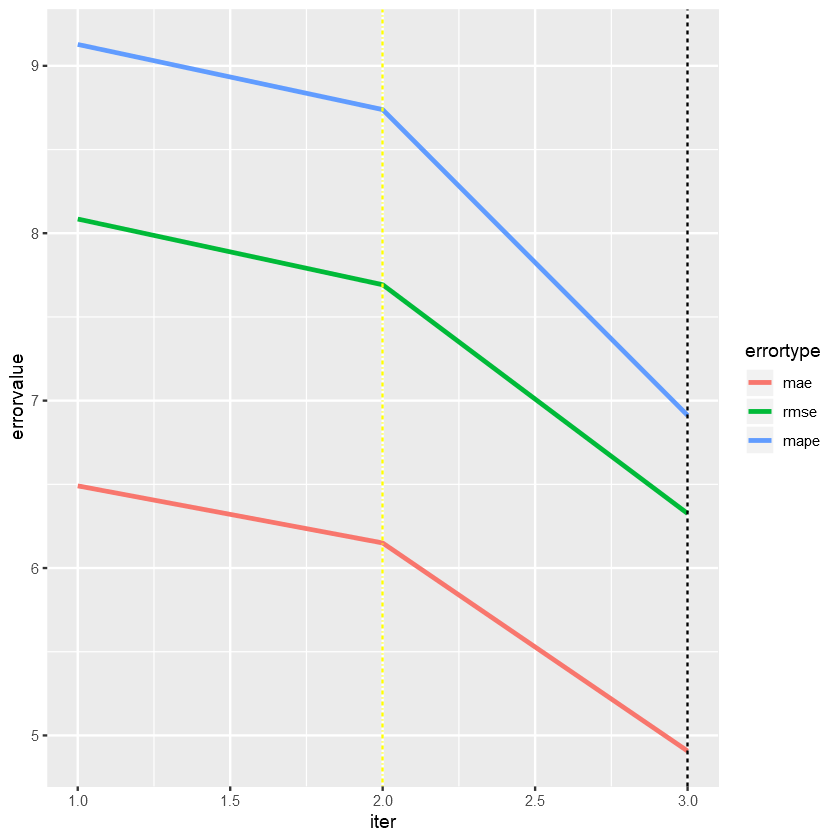

In [63]:
performance_molten_AdFe <- melt(data = performance_table_AdFe
                             , id.vars = 'iter')
setnames(performance_molten_AdFe, c("variable","value"),c("errortype","errorvalue"))
p_AdFe = ggplot(performance_molten_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
            geom_vline(xintercept = iteration_history[IsDataSelected==1]$iter_no + 1, linetype = "dotdash",color = "yellow")
p_AdFe

In [ ]:
#ggplotGrob(p_AdFe)

In [ ]:
#varImpPlot(model_Ad)

In [ ]:
NLQuit()